In [1]:
from config.config import CONNECTION_STRING, QUERY_PARAMS
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import product
from adjustText import adjust_text

In [2]:
conn = create_engine(CONNECTION_STRING).connect()

In [3]:
df = pd.read_sql("select * from offers where marker_icon = 'data'", conn)

In [4]:
df = df[df.set_index(list(QUERY_PARAMS.keys()))
                 .index.isin(list(product(QUERY_PARAMS['marker_icon'], 
             QUERY_PARAMS['experience_level'], 
             QUERY_PARAMS['city'],
             QUERY_PARAMS['workplace_type'])))]

#### Count occurences of skills per experience level

In [5]:
def count_occurences(df, filter_column1, filter_condition1, filter_column2, filter_condition2, target_column):
    df = df[[filter_column1, filter_column2, target_column]]
    df = df[df[filter_column1]==filter_condition1]
    df = df[df[filter_column2].str.contains('|'.join(filter_condition2))]
    return Counter(df[target_column].to_list())

In [6]:
occurences_junior = count_occurences(df, 'experience_level', 'junior', 
                                     'title', ['Data Scientist', 'Data Engineer', 'Machine Learning Engineer'], 'name')

In [7]:
occurences_mid = count_occurences(df, 'experience_level', 'mid', 
                                     'title', ['Data Scientist', 'Data Engineer', 'Machine Learning Engineer'], 'name')

In [8]:
all_skills = set(list(occurences_junior.keys()) + list(occurences_mid.keys()))

#### Remove too general or non-technical skills, regroup

In [9]:
skills_to_remove = {'Data', 'Data Science', 'engineering',
                     'Agile', 'Big Data', 'Transact-SQL',
                     'Python and/or Scala' }

In [10]:
all_skills = all_skills - skills_to_remove

In [12]:
occurences_mid['Python'] = occurences_mid['Python and/or Scala'] + occurences_mid['Python']

In [13]:
occurences_mid['T-SQL'] = occurences_mid['T-SQL'] + occurences_mid['Transact-SQL']

In [14]:
def skills_to_count(occurences, all_skills):
    skills_dict = {k:occurences[k] for k in all_skills }
    return skills_dict

In [15]:
skills_junior = skills_to_count(occurences_junior, all_skills)

In [16]:
skills_mid = skills_to_count(occurences_mid, all_skills)

173

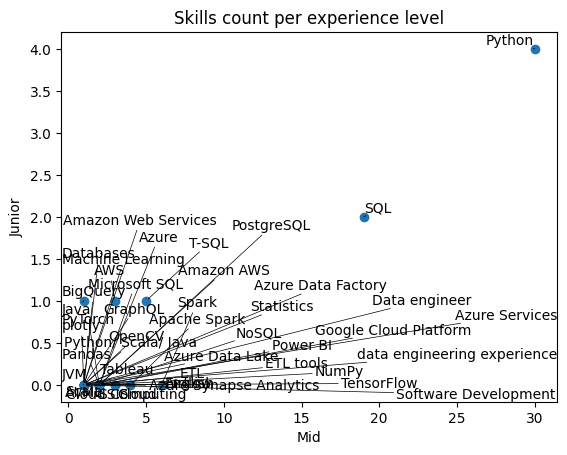

In [17]:
x = list(skills_mid.values())
y = list(skills_junior.values())
n = all_skills

plt.scatter(x,y)
plt.title('Skills count per experience level')
plt.xlabel("Mid")
plt.ylabel('Junior')

texts = [plt.text(x[i], y[i], txt) for i, txt in enumerate(n)]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))


#### Analyse at job level

In [45]:
df_job_level = df[list(set(df.columns) - set(['name', 'level', 'id']))].drop_duplicates()

In [62]:
def get_stat(df, experience_level, type):
    return df.loc[(df['experience_level'] == experience_level) & (df['type'] == type)]['salary_from'].dropna()

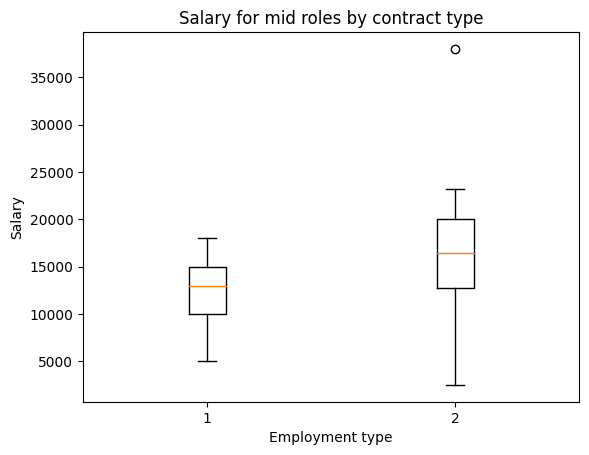

In [70]:

data = [list(get_stat(df_job_level, 'mid', 'permanent')), 
        list(get_stat(df_job_level, 'mid', 'b2b'))]
 
# Creating plot
plt.boxplot(data)

plt.title("Salary for mid roles by contract type")
plt.xlabel("Employment type")
plt.ylabel("Salary")
 
# show plot
plt.show()